In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tifffile as tiff
from tqdm import tqdm

import import_helper
import_helper.add_functions()
import neuruloid_segmentation.best_slice_from_stack as best

### Choose best slices from 3D images in a folder

In [2]:
folder_path = "../3D_image" # path containing 3D image stacks with channels
images_3D_names = [image for image in os.listdir(folder_path) if image.endswith('.tif')]
print(images_3D_names)

save_folder = "../image/example_dataset/example_image" # path to save 2D image stacks with channels
if not os.path.exists(save_folder):
    os.mkdir(save_folder)

for i in tqdm(range(len(images_3D_names))):
    print(images_3D_names[i])
    file_path = os.path.join(folder_path, images_3D_names[i])
    save_file_path = os.path.join(save_folder, images_3D_names[i])

    _ = best.save_one_best_slice_with_laplacian(file_path, save_file_path, z_axis=0, channel_axis=1, ksize=21)


['example.tif']


  0%|          | 0/1 [00:00<?, ?it/s]

example.tif


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


(4, 1600, 1600)


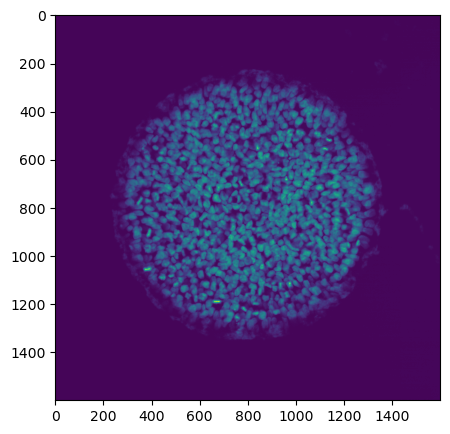

In [3]:
image_2d = os.path.join(save_folder, "example.tif")
img = tiff.imread(image_2d)
print(np.shape(img))

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(img[0, :,:]) # plot DAPI image

### Go through 3D images and choose best slice using Laplacian variance

In [4]:
folder_path = "../3D_image"
images_3D_names = [image for image in os.listdir(folder_path) if image.endswith('.tif')]
print(images_3D_names)
file_path = os.path.join(folder_path, images_3D_names[0])

image = tiff.imread(file_path)

['example.tif']


In [5]:
z_stack, n_channel, x_axis, y_axis = np.shape(image)
dapi_image = np.take(image, indices=0, axis=1) #image[:,0,:,:]

4.333237235043542e+20


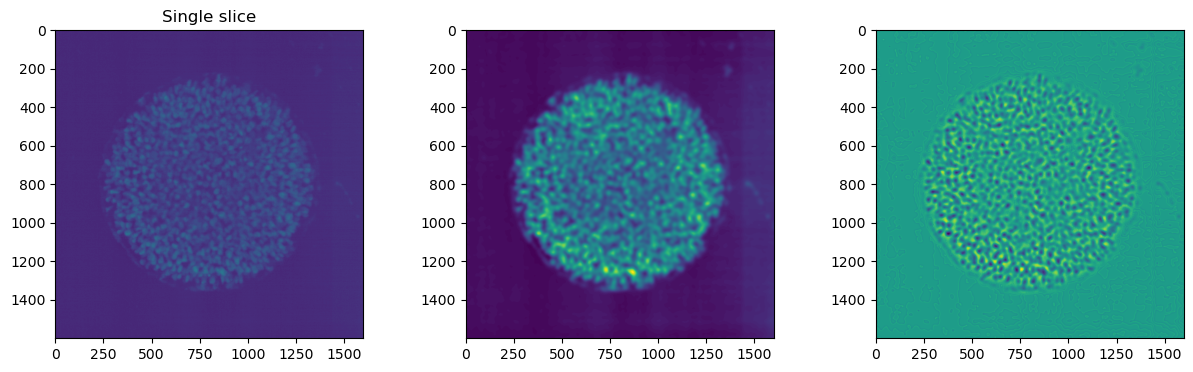

In [6]:
one_slice = np.take(dapi_image, indices=10, axis=0)
# gaussian blur
blur_slice = cv2.GaussianBlur(one_slice, (51,51), 0)
laplacian, var = best.obtain_laplacian_variance(blur_slice, ksize=21)
print(var)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].imshow(one_slice)
ax[0].set_title("Single slice")
ax[1].imshow(blur_slice)
im1 = ax[2].imshow(laplacian)
# fig.colorbar(im1)

In [7]:
# gaussian blur all slices
gaussian_dapi = np.zeros((z_stack, x_axis, y_axis))
for i in range(z_stack):
    one_slice = np.take(dapi_image, indices=i, axis=0)
    blur_slice = cv2.GaussianBlur(one_slice, (51,51), 0)
    gaussian_dapi[i,:,:] = blur_slice


Laplacian method: 21
Variance method: 19


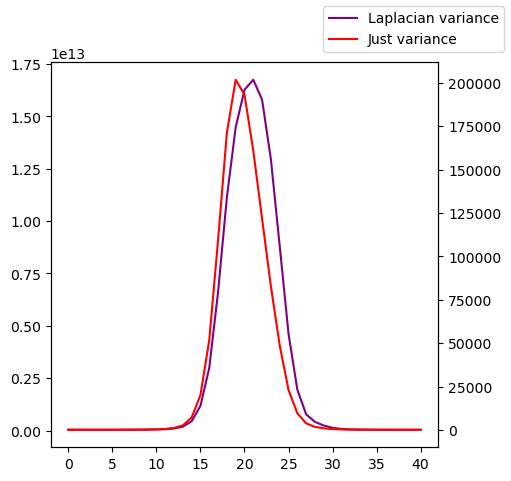

In [8]:
laplacian_idx, laplacian_values = best.focus_detection_laplacian(dapi_image, z_axis=0, ksize=11)
print(f"Laplacian method: {laplacian_idx}")
variance_idx, variance_values = best.focus_detection_variance(dapi_image, z_axis=0)
print(f"Variance method: {variance_idx}")

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(laplacian_values, label="Laplacian variance", color="Purple")

ax1 = ax.twinx()
ax1.plot(variance_values, label="Just variance", color="Red")
fig.legend()

In [9]:
kernel_sizes = np.arange(1, 31, 4)
max_lp_vals = np.zeros_like(kernel_sizes)
best_idx = np.zeros_like(kernel_sizes)
for i in tqdm(range(len(kernel_sizes))):
    best_idx[i], lp_values = best.focus_detection_laplacian(dapi_image, z_axis=0, ksize=kernel_sizes[i])
    max_lp_vals[i] = np.max(lp_values/10**20)   


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


[19 20 21 21 21 21 21 21]


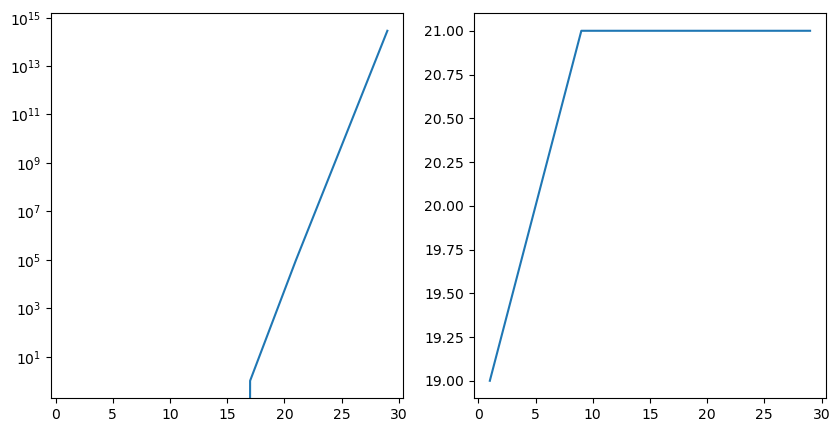

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(kernel_sizes, max_lp_vals)
ax[0].set_yscale('log')
ax[1].plot(kernel_sizes, best_idx)
print(best_idx)